In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import os, shutil

#### Data Pre-Processing 

##### Step 1 : Provide labels(names) to the data in the classlabels.txt 


In [3]:
df = pd.read_csv('classlabels.txt', sep=",", header=None)
df.columns = ["image", "class"]

# Shuffle data :
df = sklearn.utils.shuffle(df)

# Split the data (Training/Validation : 80/20) :
df_train, df_test = np.split(df, [int(.8*len(df))])


In [8]:
def createFolder(name):
    if not os.path.exists(name):
        os.makedirs(name)

##### Step 2 : Read the data from the source location : 'JF30-1/jpg/' and copy the same into the destination path.

In [9]:
SOURCE = 'JF30-1/jpg/'
def copyFile(fileName, destination):
    # ex : 'JFG30-1/jpg/JFT_000001.jpg'
    shutil.copy(SOURCE+fileName, destination)

##### Step 3 : Creating 2 Folders: 
1. train
2. validation

* All the images belonging to the initial 80% dataset will be moved to the "train" folder
* All the remaining 20% images will be moved to the "validation" folder


In [10]:
def createClassFolders(df, folderName):
    # create the main folder
    createFolder(folderName)
    # Start copying
    for idx,row in df.iterrows():
        # JFT_00001.jpg, 1
        destination = folderName+'/'+str(row['class']) # train/1
        createFolder(destination)
        copyFile(row['image'], destination)

In [11]:
createClassFolders(df_train, 'train')

In [12]:
createClassFolders(df_test, 'validation')

* The 2 Folders have been created and there are 30 individual folders within each of them (from 1 - 30), for each of the 30 Image Classes.

#### QUESTION 1 : Model 1 from scratch using CNN layers

##### Baseline Model for comparison of Accuracy metrics :


In [107]:
baseline_accuracy = df['class'].value_counts()/len(df)
print("Accuracy of the Baseline Model is:", baseline_accuracy)


Accuracy of the Baseline Model is: 6     0.047329
28    0.045977
23    0.045301
13    0.044625
4     0.044625
2     0.043949
7     0.043272
18    0.042596
29    0.042596
20    0.041244
27    0.041244
24    0.040568
10    0.040568
25    0.037863
19    0.037187
14    0.036511
5     0.036511
22    0.033130
12    0.032454
9     0.031102
17    0.030426
3     0.027721
21    0.025693
11    0.024341
26    0.023665
8     0.018932
16    0.016227
15    0.008790
30    0.008114
1     0.007437
Name: class, dtype: float64


In [13]:

import tensorflow as tf
from tensorflow import keras
from IPython import display
from tensorflow.python.data import Dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout, GaussianNoise, GaussianDropout
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers
print(tf.__version__)
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers

2.3.0


In [14]:
# create a data generator
trainDataGen = ImageDataGenerator(rescale=1./255,
          rotation_range=5,
          zoom_range=0.2,
          horizontal_flip=True)
valDataGen = ImageDataGenerator(rescale=1./255) 

In [15]:
# load and iterate training dataset
SIZE=150
train = trainDataGen.flow_from_directory('train',target_size=(SIZE, SIZE), class_mode='categorical', batch_size=30)

# load and iterate validation dataset
val = valDataGen.flow_from_directory('validation',target_size=(SIZE, SIZE), class_mode='categorical', batch_size=30)

Found 1183 images belonging to 30 classes.
Found 296 images belonging to 30 classes.


In [16]:
model = Sequential()
model.add(keras.layers.InputLayer(input_shape=(SIZE, SIZE, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), padding="same", input_shape=(SIZE, SIZE, 3), activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation="relu"))

model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(30, activation="softmax"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

##### Training the CNN Model :

In [19]:
model_metrics = model.fit_generator(
      train,
      steps_per_epoch=train.samples // train.batch_size ,
      epochs=10,
      validation_data=val,
      validation_steps=val.samples // val.batch_size,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
39/39 [==============================] - 89s 2s/step - loss: 2.7420 - acc: 0.2350 - val_loss: 3.0923 - val_acc: 0.1556
Epoch 2/10
39/39 [==============================] - 89s 2s/step - loss: 1.9826 - acc: 0.4232 - val_loss: 2.6295 - val_acc: 0.2630
Epoch 3/10
39/39 [==============================] - 88s 2s/step - loss: 1.5045 - acc: 0.5646 - val_loss: 2.1778 - val_acc: 0.4704
Epoch 4/10
39/39 [==============================] - 91s 2s/step - loss: 1.2881 - acc: 0.6062 - val_loss: 1.7475 - val_acc: 0.6370
Epoch 5/10
39/39 [==============================] - 92s 2s/step - loss: 1.1073 - acc: 0.6609 - val_loss: 1.4967 - val_acc: 0.6370
Epoch 6/10
39/39 [==============================] - 91s 2s/step - loss: 0.9645 - acc: 0.6860 - val_loss: 1.2029 - val_acc: 0.6926
Epoch 7/10
39/39 [==============================] - 89s 2s/step - loss: 0.8518 - acc: 0.7502 - val_loss: 1.0126 - val_acc: 0.7481
Epoch 8/10
39/

##### Accuracy of this Model :

In [20]:
print("Validation Accuracy:", max(model_metrics.history['val_acc']))
print("Training Accuracy", max(model_metrics.history['acc']))

Validation Accuracy: 0.7962962985038757
Training Accuracy 0.8057242035865784


##### Graphs for the above CNN Model :

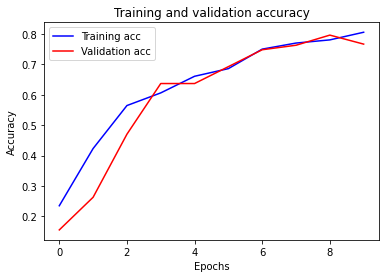

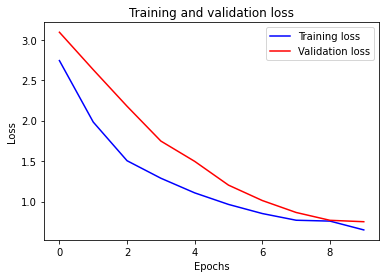

In [110]:
acc = model_metrics.history['acc']
val_acc = model_metrics.history['val_acc']
loss = model_metrics.history['loss']
val_loss = model_metrics.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### QUESTION 2 : Model 2: Use Transfer learning or fine tuning

In [21]:
from keras.applications import VGG16
 
vgg_conv = VGG16(weights='imagenet',include_top=False,input_shape=(SIZE, SIZE, 3))

58892288/58889256 [==============================] - 14s 0us/step


In [22]:
# Freezing all the layers except the last 4 layers by using the parameter trainable = False  :
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001D9AA50EE88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D9AC1AF848> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D9AC17F648> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001D9AC1CCE08> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D9ABB6DC88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D9AC1CE788> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001D9AC1D3548> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D9AC1D4F48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D9AC1D7908> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D9AC1DD388> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001D9AC1DFE88> False
<tensorflow.python.

In [23]:
# Create the model for Transfer Learning :
model_vgg = keras.models.Sequential()

# Add the vgg convolutional base model
model_vgg.add(vgg_conv)
 
# Add new custom layers
model_vgg.add(keras.layers.Flatten()) # Removing all the dimensions
model_vgg.add(keras.layers.Dense(1024, activation='relu'))
model_vgg.add(keras.layers.Dropout(0.5)) # Prevent model from overfitting by setting random layers to 0
model_vgg.add(keras.layers.Dense(1024, activation='relu'))
model_vgg.add(keras.layers.Dense(1024, activation='relu'))
model_vgg.add(keras.layers.Dense(30, activation= tf.nn.softmax))
 
# Show a summary of the model. Check the number of trainable parameters
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 30)               

In [24]:
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

TRAINING THE MODEL :

In [25]:
new_metrics = model_vgg.fit_generator(
      train,
      steps_per_epoch=train.samples // train.batch_size ,
      epochs=10,
      validation_data=val,
      validation_steps=val.samples // val.batch_size,
      verbose=1)

Epoch 1/10
39/39 [==============================] - 255s 7s/step - loss: 2.4545 - acc: 0.3140 - val_loss: 1.3181 - val_acc: 0.6296
Epoch 2/10
39/39 [==============================] - 234s 6s/step - loss: 1.0307 - acc: 0.6791 - val_loss: 0.6523 - val_acc: 0.7519
Epoch 3/10
39/39 [==============================] - 238s 6s/step - loss: 0.5997 - acc: 0.8066 - val_loss: 0.5781 - val_acc: 0.8519
Epoch 4/10
39/39 [==============================] - 258s 7s/step - loss: 0.4103 - acc: 0.8638 - val_loss: 0.2973 - val_acc: 0.9111
Epoch 5/10
39/39 [==============================] - 244s 6s/step - loss: 0.3275 - acc: 0.8985 - val_loss: 0.1501 - val_acc: 0.9370
Epoch 6/10
39/39 [==============================] - 239s 6s/step - loss: 0.2310 - acc: 0.9297 - val_loss: 0.3238 - val_acc: 0.9000
Epoch 7/10
39/39 [==============================] - 250s 6s/step - loss: 0.2159 - acc: 0.9332 - val_loss: 0.4046 - val_acc: 0.8889
Epoch 8/10
39/39 [==============================] - 241s 6s/step - loss: 0.1413 - a

##### Determining the Accuracy of this Model :

In [27]:
print("Validation Accuracy:", max(new_metrics.history['val_acc']))
print("Training Accuracy", max(new_metrics.history['acc']))

Validation Accuracy: 0.9518518447875977
Training Accuracy 0.9644405841827393


##### Load a sample image for Prediction :

In [28]:
from keras.preprocessing import image
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(SIZE, SIZE))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

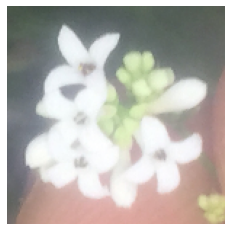

In [29]:
img = load_image(SOURCE+'JFT_00001.jpg', True)

##### Predict the class of the above image through our Model :

In [50]:
pred_val = model_vgg.predict(img) 
pred = np.argmax(pred_val, axis=-1)
print(pred_val)
print(pred)

[[9.9406946e-01 1.1003522e-06 3.4257536e-07 1.0979796e-05 1.0276963e-04
  2.2450900e-03 6.6834355e-06 1.6263151e-05 7.3690927e-07 3.4295459e-04
  3.5069195e-05 3.3653680e-07 3.0357183e-03 1.4679766e-06 7.2947623e-06
  9.2769524e-06 1.2777420e-05 8.7619237e-06 1.5807097e-06 5.9843574e-06
  1.2857595e-05 3.6126708e-06 4.4676522e-08 2.8213441e-07 1.5234874e-06
  2.8735764e-07 1.2805415e-07 1.8328705e-06 3.3633708e-06 6.1873514e-05]]
[0]


In [57]:
# The above prediction will return the index of the maximum value of this array (which begins with 0 always).
# Hence predicting the class as follows :

pred = np.argmax(model_vgg.predict(img))
print("The Image belongs to Class", pred+1)
    

The Image belongs to Class 1


#### Verifying the prediction with the actual class :

In [77]:
actual_class = df.loc[df['image'] == 'JFT_00001.jpg']['class']
actual_class

0    1
Name: class, dtype: int64

##### FEW SAMPLE PREDICTIONS ON THE VALIDATION DATA :

In [81]:
# Training Data sample predictions :
pred_val = model_vgg.predict_classes(val, batch_size=10) 
print(pred_val[:5])

[25 13 24 15 20]


##### OVERALL PREDICTIONS SUMMARY

In [82]:
test_steps_per_epoch = val.samples // val.batch_size
predictions = model.predict_generator(val, steps=test_steps_per_epoch)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [108]:
predicted_classes[:5]

array([22, 29,  9, 27, 19], dtype=int64)

In [84]:
true_classes = val.classes
class_labels = list(val.class_indices.keys())  

from sklearn import metrics

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

##### PLOTS FOR THE ABOVE MODEL :

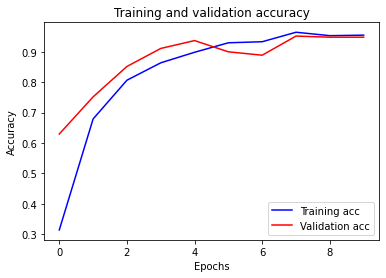

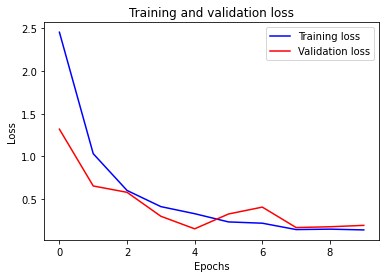

In [87]:
acc = new_metrics.history['acc']
val_acc = new_metrics.history['val_acc']
loss = new_metrics.history['loss']
val_loss = new_metrics.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Observations :

 
* For this problem statement, we have used an initial CNN Model which has been built from scratch and trained.
- The Baseline Model has a maximum accuracy of 4.6%.
- The CNN Model has a Validation Accuracy of 79.6%.
- But the last model which was built using Transfer Learning technique utilizing the existing VGG model, has an overall Accuracy of 95%.

* As can be seen from the above metrics, Transfer Learning model has the highest Accuracy.

* This suggests that Models evidently do well with Transfer learning techniques, since the existing model has already been trained on huge data and has been proven to be good at classifying the output classes with a high accuracy rate.

* Also, the most important advantage of using this technique is that the Model need not be built from scratch. Most of the existing model layers can conveniently be re-used.
- Only the last but one layer and the Output layers would require to be re-trained.

* Transfer Learning is mostly used in the following scenarios :
 - When the labeled training data is not sufficient enough to train our network from scratch.
 - There is an existing pre-trained model which was built for a similar task and has been trained on massive amounts of data.
